# Clothoid Exploration

Due to a personal project I got somewhat involved with clothoids (also known as Euler spiral or Cornu spiral). I mainly wanted to analytically determine the **distance to a point** and **get a bounding box**. The main feature of a clothoid is that is has a **linearly increasing curvature** which makes it a ideal transition between two curvatures. Basis of the clothoid are the Fresnel integrals.

\begin{equation*}
S(s) = \int_0^s sin(\frac{1}{2} \pi t^2) dt
\end{equation*}

\begin{equation*}
C(s) = \int_0^s cos(\frac{1}{2} \pi t^2) dt
\end{equation*}

In [16]:
import matplotlib.pyplot as plt
import scipy.special as sc
import numpy as np
%matplotlib inline

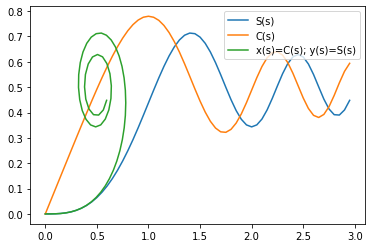

In [17]:
s_vals = np.arange(0.0, 3.0, 0.05)
S, C = sc.fresnel(s_vals)
plt.plot(s_vals, S, label="S(s)")
plt.plot(s_vals, C, label="C(s)")
plt.plot(C, S, label="x(s)=C(s); y(s)=S(s)")
plt.legend(loc="upper right")

As you can see if we use $x(l)=C(l)$ and $y(l)=C(l)$ we get the typical shape of a clothoid. There is also a constant which controls the incline in curvature (*a*). For the library I used the formula was:

\begin{equation*}
\begin{pmatrix}x \\ y \end{pmatrix}(s) = a*\int_0^{\frac{s}{a}} \begin{pmatrix}cos(\frac{1}{2} \pi t^2) \\ sin(\frac{1}{2} \pi t^2) \end{pmatrix} dt
\end{equation*}

\begin{equation*}
a = \sqrt{\frac{\pi}{\lvert \dot c \rvert}}
\end{equation*}

Where $\dot c$ is the derivate of curvature $c$. The curvature is in $\frac{1}{m}$ and dictates the radius a circle would have a certain point along the clothoid. Using different $\dot c$ values gives us an impresssion how this parameter affects the shape. Also we can get the tangent angle of any point on the clothoid via:

\begin{equation*}
\alpha_{tangent} = \frac{1}{2} s^2 \dot c
\end{equation*}

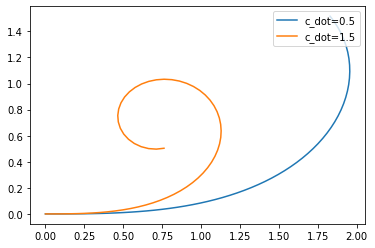

In [18]:
s_vals = np.arange(0.0, 3.0, 0.05)
a_1 = np.sqrt(np.pi/np.abs(0.5))
S_1, C_1 = sc.fresnel([s/a_1 for s in s_vals])
plt.plot([a_1*x for x in C_1], [a_1*y for y in S_1], label="c_dot=0.5")

a_2 = np.sqrt(np.pi/np.abs(1.5))
S_2, C_2 = sc.fresnel([s/a_2 for s in s_vals])
plt.plot([a_2*x for x in C_2], [a_2*y for y in S_2], label="c_dot=1.5")

plt.legend(loc="upper right")

Another way to describe a clothoid is by giving a start ($c_{start}$) and end curvature ($c_{end}$) and the length. We can simply derive $\dot c = \frac{c_{end}-c_{start}}{l}$. To still keep the clothoid origin at $(0,0)$ and keep the initial slope at 0 we use the below formula. This basically gets the angle at $c_{start}$ ($\alpha_0$) and turns the clothoid by this angle. We can get the start arclength via $s_{start} = \frac{c_{start}}{\dot c}$ and subsequently $\alpha_0$ via the above formula.

\begin{equation*}
x(s) = (\cos(-\alpha_0) * (x(s)-x(s_{start})) - (\sin(-\alpha_0) * (y(s)-y(s_{start}))
\end{equation*}

\begin{equation*}
y(s) = (\sin(-\alpha_0) * (x(s)-x(s_{start})) + (\cos(-\alpha_0) * (y(s)-y(s_{start})) 
\end{equation*}